In [5]:
# Author: Lukas Gemein <l.gemein@gmail.com>
#
# License: BSD (3-clause)

import tempfile

import numpy as np
import matplotlib.pyplot as plt
import mne

from braindecode.datasets import TUH
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, scale as multiply)


plt.style.use('seaborn')
mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

%matplotlib inline

In [2]:
from braindecode.datasets.tuh import _TUHMock as TUH  # noqa F811

In [3]:
TUH_PATH = '/scratch/tuh/'
N_JOBS = 2  # specify the number of jobs for loading and windowing
tuh = TUH(
    path=TUH_PATH,
    recording_ids=None,
    target_name=None,
    preload=False,
    add_physician_reports=False,
    n_jobs=1 if TUH.__name__ == '_TUHMock' else N_JOBS,  # Mock dataset can't
    # be loaded in parallel
)

Text(0, 0.5, 'Count')

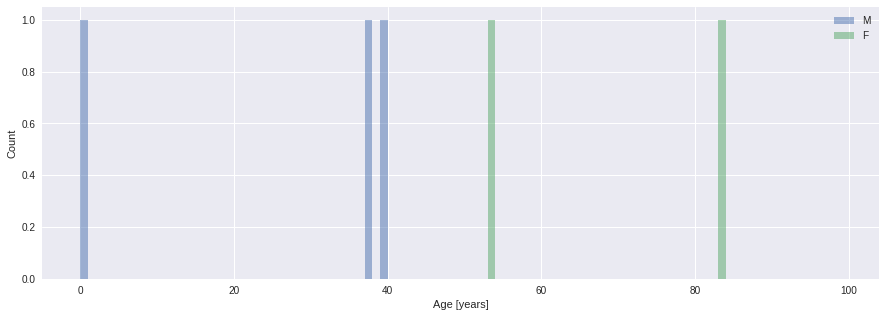

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
genders = tuh.description.gender.unique()
x = [tuh.description.age[tuh.description.gender == g] for g in genders]
ax.hist(
    x=x,
    stacked=True,
    bins=np.arange(100, dtype=int),
    alpha=.5,
)
ax.legend(genders)
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')

In [7]:
def load_example_data(preload, window_len_s, n_subjects=10):
    """Create windowed dataset from subjects of the TUH Abnormal dataset.

    Parameters
    ----------
    preload: bool
        If True, use eager loading, otherwise use lazy loading.
    n_subjects: int
        Number of subjects to load.

    Returns
    -------
    windows_ds: BaseConcatDataset
        Windowed data.

    .. warning::
        The recordings from the TUH Abnormal corpus do not all share the same
        sampling rate. The following assumes that the files have already been
        resampled to a common sampling rate.
    """
    subject_ids = list(range(n_subjects))
    ds = TUHAbnormal(
        TUH_PATH, subject_ids=subject_ids, target_name='pathological',
        preload=preload)

    fs = ds.datasets[0].raw.info['sfreq']
    window_len_samples = int(fs * window_len_s)
    window_stride_samples = int(fs * 4)
    # window_stride_samples = int(fs * window_len_s)
    windows_ds = create_fixed_length_windows(
        ds, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=window_len_samples,
        window_stride_samples=window_stride_samples, drop_last_window=True,
        preload=preload, drop_bad_windows=True)

    # Drop bad epochs
    # XXX: This could be parallelized.
    # XXX: Also, this could be implemented in the Dataset object itself.
    for ds in windows_ds.datasets:
        ds.windows.drop_bad()
        assert ds.windows.preload == preload

    return windows_ds


def create_example_model(n_channels, n_classes, window_len_samples,
                         kind='shallow', cuda=False):
    """Create model, loss and optimizer.

    Parameters
    ----------
    n_channels : int
        Number of channels in the input
    n_times : int
        Window length in the input
    n_classes : int
        Number of classes in the output
    kind : str
        'shallow' or 'deep'
    cuda : bool
        If True, move the model to a CUDA device.

    Returns
    -------
    model : torch.nn.Module
        Model to train.
    loss :
        Loss function
    optimizer :
        Optimizer
    """
    if kind == 'shallow':
        model = ShallowFBCSPNet(
            n_channels, n_classes, input_window_samples=window_len_samples,
            n_filters_time=40, filter_time_length=25, n_filters_spat=40,
            pool_time_length=75, pool_time_stride=15, final_conv_length='auto',
            split_first_layer=True, batch_norm=True, batch_norm_alpha=0.1,
            drop_prob=0.5)
    elif kind == 'deep':
        model = Deep4Net(
            n_channels, n_classes, input_window_samples=window_len_samples,
            final_conv_length='auto', n_filters_time=25, n_filters_spat=25,
            filter_time_length=10, pool_time_length=3, pool_time_stride=3,
            n_filters_2=50, filter_length_2=10, n_filters_3=100,
            filter_length_3=10, n_filters_4=200, filter_length_4=10,
            first_pool_mode="max", later_pool_mode="max", drop_prob=0.5,
            double_time_convs=False, split_first_layer=True, batch_norm=True,
            batch_norm_alpha=0.1, stride_before_pool=False)
    else:
        raise ValueError

    if cuda:
        model.cuda()

    optimizer = optim.Adam(model.parameters())
    loss = nn.NLLLoss()

    return model, loss, optimizer


def run_training(model, dataloader, loss, optimizer, n_epochs=1, cuda=False):
    """Run training loop.

    Parameters
    ----------
    model : torch.nn.Module
        Model to train.
    dataloader : torch.utils.data.Dataloader
        Data loader which will serve examples to the model during training.
    loss :
        Loss function.
    optimizer :
        Optimizer.
    n_epochs : int
        Number of epochs to train the model for.
    cuda : bool
        If True, move X and y to CUDA device.

    Returns
    -------
    model : torch.nn.Module
        Trained model.
    """
    for i in range(n_epochs):
        loss_vals = list()
        for X, y, _ in dataloader:
            model.train()
            model.zero_grad()

            y = y.long()
            if cuda:
                X, y = X.cuda(), y.cuda()

            loss_val = loss(model(X), y)
            loss_vals.append(loss_val.item())

            loss_val.backward()
            optimizer.step()

        print(f'Epoch {i + 1} - mean training loss: {np.mean(loss_vals)}')

    return model

In [8]:
from itertools import product
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import mne
import numpy as np
import pandas as pd
import seaborn as sns

from braindecode.datasets import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.models import ShallowFBCSPNet, Deep4Net

In [9]:
PRELOAD = [True, False]  # True -> eager loading; False -> lazy loading
N_SUBJECTS = [10]  # Number of recordings to load from the TUH Abnormal corpus
WINDOW_LEN_S = [2, 4, 15]  # Window length, in seconds
N_EPOCHS = [2]  # Number of epochs to train the model for
BATCH_SIZE = [64, 256]  # Training minibatch size
MODEL = ['shallow', 'deep']

NUM_WORKERS = [8, 0]  # number of processes used by pytorch's Dataloader
PIN_MEMORY = [False]  # whether to use pinned memory
CUDA = [True, False] if torch.cuda.is_available() else [False]  # whether to use a CUDA device

N_REPETITIONS = 3  # Number of times to repeat the experiment (to get better time estimates)

In [10]:
TUH_PATH = ('/scratch/tuh/edf/')

In [11]:
all_results = list()
for (i, preload, n_subjects, win_len_s, n_epochs, batch_size, model_kind,
        num_workers, pin_memory, cuda) in product(
            range(N_REPETITIONS), PRELOAD, N_SUBJECTS, WINDOW_LEN_S, N_EPOCHS,
            BATCH_SIZE, MODEL, NUM_WORKERS, PIN_MEMORY, CUDA):

    results = {
        'repetition': i,
        'preload': preload,
        'n_subjects': n_subjects,
        'win_len_s': win_len_s,
        'n_epochs': n_epochs,
        'batch_size': batch_size,
        'model_kind': model_kind,
        'num_workers': num_workers,
        'pin_memory': pin_memory,
        'cuda': cuda
    }
    print(f'\nRepetition {i + 1}/{N_REPETITIONS}:\n{results}')

    # Load the dataset
    data_loading_start = time.time()
    dataset = load_example_data(preload, win_len_s, n_subjects=n_subjects)
    data_loading_end = time.time()

    # Create the data loader
    training_setup_start = time.time()
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory,
        num_workers=num_workers, worker_init_fn=None)

    # Instantiate model and optimizer
    n_channels = len(dataset.datasets[0].windows.ch_names)
    n_times = len(dataset.datasets[0].windows.times)
    n_classes = 2
    model, loss, optimizer = create_example_model(
        n_channels, n_classes, n_times, kind=model_kind, cuda=cuda)
    training_setup_end = time.time()

    # Start training loop
    model_training_start = time.time()
    trained_model = run_training(
        model, dataloader, loss, optimizer, n_epochs=n_epochs, cuda=cuda)
    model_training_end = time.time()

    del dataset, model, loss, optimizer, trained_model

    # Record timing results
    results['data_preparation'] = data_loading_end - data_loading_start
    results['training_setup'] = training_setup_end - training_setup_start
    results['model_training'] = model_training_end - model_training_start
    all_results.append(results)


Repetition 1/3:
{'repetition': 0, 'preload': True, 'n_subjects': 10, 'win_len_s': 2, 'n_epochs': 2, 'batch_size': 64, 'model_kind': 'shallow', 'num_workers': 8, 'pin_memory': False, 'cuda': True}


TypeError: __init__() got an unexpected keyword argument 'subject_ids'